# Predicting depression through social media

In [25]:
%matplotlib inline
from pyspark.context import SparkContext
import datetime
from os import path
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)


In [26]:
sc = SparkContext.getOrCreate()
truePositivesPath = "../truePositives/*.csv"
trueNegativesPath = "../trueNegatives/*.csv"

## Helper Functions

In [27]:
def isTimeStamp(date_text):
    if date_text is None: 
        return False
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d %H:%M:%S')
        return True
    except ValueError, TypeError:
        return False

In [28]:
def make_word_cloud(mask_file_path, text, title):
    """This method creates a word cloud based on the word count from the given text."""
    d = path.dirname(".")
    mask_image = np.array(Image.open(path.join(d, mask_file_path)))
    stopwords = set(STOPWORDS)
    stopwords.add("said")
    stopwords.add("https")
    stopwords.add("co")
    stopwords.add("amp")
    stopwords.add("RT")

    wc = WordCloud(background_color="white", max_words=2000, mask=mask_image, stopwords=stopwords)
    # generate word cloud
    wc.generate(text)

    # store to file
    wc.to_file(path.join(d, title+".png"))
    
    # show
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.figure()
    plt.show() 

## Creating a word cloud 

In [29]:
tp_dataframe = spark.read.options(header="true", parserLib="univocity").csv(truePositivesPath)

tn_dataframe = spark.read.options(header="true", parserLib="univocity").csv(trueNegativesPath)

In [31]:
tp_rdd = tp_dataframe.rdd\
                     .map(list)\
                     .filter(lambda line: isTimeStamp(line[1]))\
                     .cache()
                     
tn_rdd = tn_dataframe.rdd\
                     .map(list)\
                     .filter(lambda line: isTimeStamp(line[1]))\
                     .cache()
                     
            
print tp_rdd.count()
print tn_rdd.count()

85281
793


In [32]:
tp_text_rdd = tp_rdd.map(lambda line: [str(re.sub(r'[^\x00-\x7F]+',' ', line[-1]))]).cache()
tn_text_rdd = tn_rdd.map(lambda line: [str(re.sub(r'[^\x00-\x7F]+',' ', line[-1]))]).cache()

tp_text_rdd.take(5)
tn_text_rdd.take(5)


[['@P727 @elonmusk However   Lets wait for one right now... May be iphone8 can be an innovation..! (2/2)'],
 ['@P727 @elonmusk Yeah! all knows @elonmusk as father of innovation of present decade same as Steve Jobs. Sure,  https://t.co/S11V8gAGhM'],
 ["@P727 They should buy @elonmusk 's brain and actions. Money don't make people innovative. Sim. Innovation alone not  https://t.co/XRFnikz9mb"],
 ['Tesla needs cash (which Apple has). Apple needs innovation (which Tesla has). Should Apple buy Tesla?#acquisition #rumors #Netflix #Disney'],
 ["Four of the wildest ideas from Amazon's Jeff Bezos https://t.co/9ioANNpbUw via @usatoday"]]

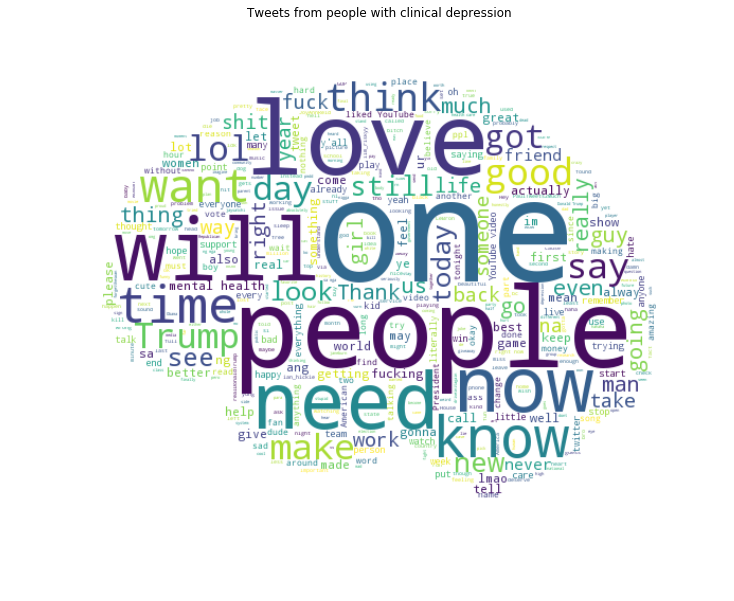

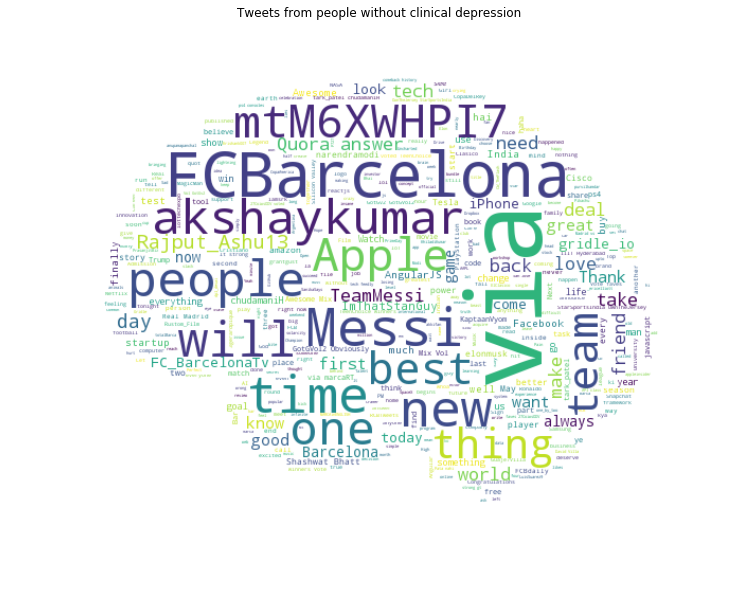

In [33]:
tp_collect = tp_text_rdd.collect()
tn_collect = tn_text_rdd.collect()

tp_text = ''.join(str(r) for v in tp_collect for r in v)
tn_text = ''.join(str(r) for v in tn_collect for r in v)

tp_title = "Tweets from people with clinical depression"
tn_title = "Tweets from people without clinical depression"
make_word_cloud("brain1.jpg", tp_text, tp_title)
make_word_cloud("brain1.jpg", tn_text, tn_title)

## Analyzing the data with TF-IDF

In [49]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

In [52]:
tp_label_text = tp_text_rdd.map(lambda line : [-1, str(line)])
tn_label_text = tn_text_rdd.map(lambda line : [1, str(line)])

tweetRDD = tp_label_text.union(tn_label_text).collect()

tweetsDF = spark.createDataFrame(tweetRDD, ['label', 'tweet'])

splits = tweetsDF.randomSplit([0.6, 0.4])
training_df = splits[0]
test_df = splits[1]


In [61]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
idf = IDF(minDocFreq=3, inputCol="features", outputCol="idf")
nb = NaiveBayes()
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, nb])


paramGrid = ParamGridBuilder().addGrid(nb.smoothing, [0.0, 1.0]).build()


cv = CrossValidator(estimator=pipeline, 
                    estimatorParamMaps=paramGrid, 
                    evaluator=MulticlassClassificationEvaluator(), 
                    numFolds=4)

cvModel = cv.fit(training_df)

In [55]:
result = cvModel.transform(test_df)
prediction_df = result.select("tweet", "label", "prediction")

In [56]:
tpDF = prediction_df.filter(prediction_df['label']==-1.0)
tpDF.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|tweet                                                                                                                                           |label|prediction|
+------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|["  A real protester gives Oregon mayor a Pepsi. It didn't end well https://t.co/xDbMwWwXYL via @HuffPostWeird"]                                |-1   |0.0       |
|["  but for real. The wind don't play https://t.co/Jz2n6KaIlE"]                                                                                 |-1   |0.0       |
|[" Maghantay ka na lang kasi mararamdaman mo naman sa puso mo kung siya na talaga ang tamang lalaki para sa'yo...... https://t.co/xb7fLE5aKI"]  |-1   |0.0       |
|[" Malinaw ang 

In [57]:
tnDF = prediction_df.filter(prediction_df['label']==1.0)
tnDF.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|tweet                                                                                                                                           |label|prediction|
+------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|["&lt;strong&gt;Barcelona's victory parade&lt;/strong&gt; https://t.co/MG5bAOEsY9 via @marca"]                                                  |1    |0.0       |
|["@P727 They should buy @elonmusk 's brain and actions. Money don't make people innovative. Sim. Innovation alone not  https://t.co/XRFnikz9mb"]|1    |0.0       |
|["@purvilkamdar an arsenal player's most trophies won't let him make Legend...he will be a kid against Messi who can bite that kid anytime  "]  |1    |0.0       |
|["@purvilkamdar

In [59]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(result, {evaluator.metricName: "accuracy"})

0.00026058254676009036